# SCGEN:  Batch-Removal

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scgen[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/scgen@$branch#egg=scgen[tutorials]

     |████████████████████████████████| 72 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.12 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 9.1 MB/s 
     |████████████████████████████████| 96 kB 6.0 MB/s 
     |████████████████████████████████| 260 kB 51.3 MB/s 
     |████████████████████████████████| 8.8 MB 27.7 MB/s 
     |████████████████████████████████| 4.8 MB 48.3 MB/s 
     |████████████████████████████████| 1.4 MB 40.0 MB/s 
     |████████████████████████████████| 48 kB 6.0 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 224 kB 57.8 MB/s 
     |█████████████████

In [2]:
import scanpy as sc
import scgen

Global seed set to 0


### Loading Train Data

In [3]:
train = sc.read(
    "./tests/data/pancreas.h5ad",
    backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1"
)

  0%|          | 0.00/176M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata

In [5]:
train.obs["cell_type"] = train.obs["celltype"].tolist()
sc.pp.neighbors(train)
sc.tl.umap(train)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


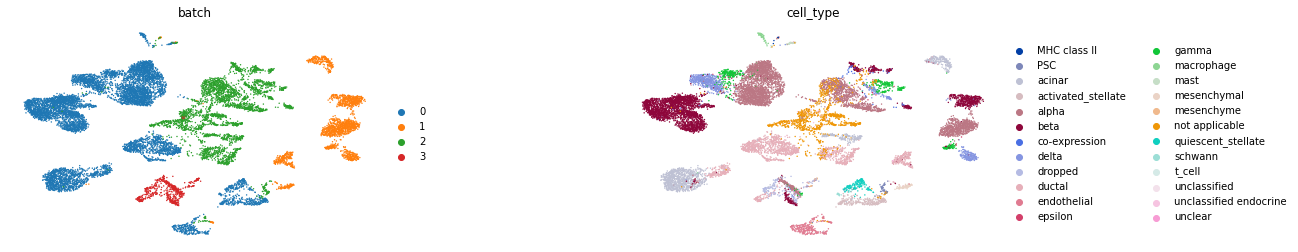

In [6]:
sc.pl.umap(train, color=["batch", "cell_type"], wspace=.5, frameon=False)

### Preprocessing Data

In [7]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="cell_type")

/usr/local/lib/python3.7/dist-packages/scvi/data/_utils.py:158: UserWarning: Category 21 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  category, alternate_column_key


## Creating and Saving the model¶

In [8]:
model = scgen.SCGEN(train)
model.save("../saved_models/model_batch_removal.pt", overwrite=True)

## Training the Model

In [9]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27/100:  27%|██▋       | 27/100 [02:36<07:01,  5.78s/it, loss=774, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 2336.101. Signaling Trainer to stop.


## Batch-Removal 

In [10]:
corrected_adata = model.batch_removal()
corrected_adata

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/usr/local/lib/python3.7/dist-packages/scvi/data/_utils.py:158: UserWarning: Category 21 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  category, alternate_column_key


AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain', 'cell_type', '_scvi_batch', '_scvi_labels', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

### Visualization of the corrected gene expression data¶

         Falling back to preprocessing with `sc.pp.pca` and default params.


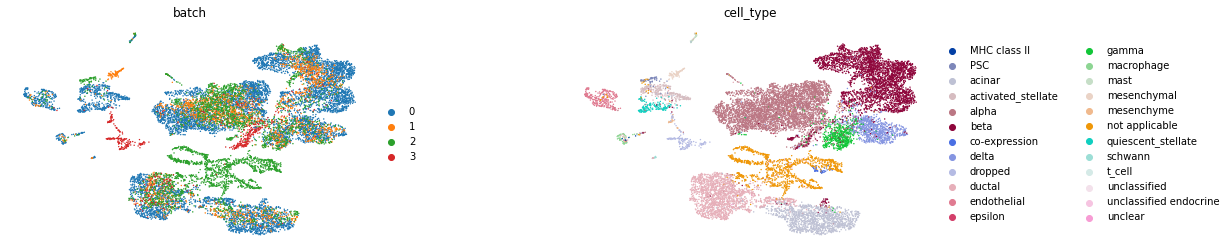

In [11]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

We can also use low-dim corrected gene expression data

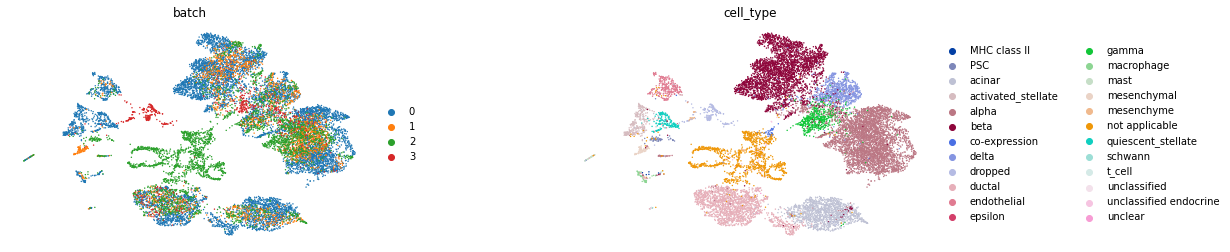

In [12]:
sc.pp.neighbors(corrected_adata, use_rep="corrected_latent")
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

### Using Uncorrected Data

Note that original adata.raw for the adata.raw is saved to corrected_adata.raw and you can use that for fruther analaysis

In [13]:
corrected_adata.raw

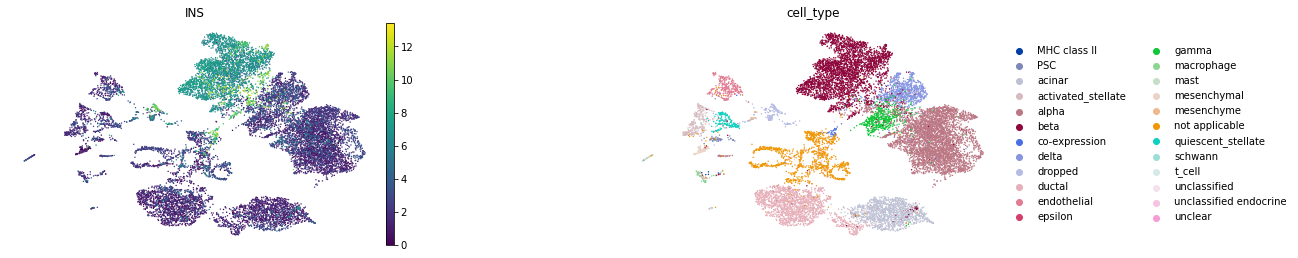

In [14]:
sc.pl.umap(corrected_adata, color=["INS", "cell_type"], wspace=.5, frameon=False, use_raw=True)
